# Compute mutation profiles and uni-mutational fractions
"Mutation profile": Number of positions with one mutation, number of positions with two mutations, etc.


**IMPORTANT NOTE**: We omit 0 values from mutation profile plots (i.e. numbers of mutations where 0 positions have exactly that many mutations). This both unclutters the plots AND lets us use normal log scales without problems. Plotting 0 values in a log scale is doable using pyplot's symlog option, but this isn't necessary for these plots at least.

(it's not really an "important note", but I spent like an hour trying to understand this when recreating these plots elsewhere...)

In [4]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"
%run "GeneUtils.ipynb"

In [5]:
from collections import defaultdict
import os

def get_mutation_profile(seq):
    num_mutations_to_freq = defaultdict(int)
    for pos in seq2pos2matchct[seq]:
        mismatch_and_match_ct = seq2pos2matchct[seq][pos] + seq2pos2mismatchct[seq][pos]
        # ignore uncovered places. Could also ignore places with less than some threshold coverage (e.g. 5).
        if mismatch_and_match_ct == 0:
            continue
        num_mutations_to_freq[seq2pos2mismatchct[seq][pos]] += 1
    return num_mutations_to_freq

def view_mutation_profiles(xlim_max=None, ylim_max=None, logscale=False):
    for seq in SEQS:
        num_mutations_to_freq = get_mutation_profile(seq)
        
        # .keys() and .values() should be in the same order: https://stackoverflow.com/a/835430
        pyplot.scatter(num_mutations_to_freq.keys(), num_mutations_to_freq.values(), c=SCATTERPLOT_PT_COLOR)
        
        ylabel = "How many positions have\nthis many mutations?"
        if logscale:
            # https://stackoverflow.com/a/14530857
            pyplot.gca().set_yscale("log")
            ylabel += " (log$_{10}$ scale)"
        pyplot.xlabel("Number of mutations")
        pyplot.ylabel(ylabel)
        
        title = "{}: Mutation Profile".format(seq2name[seq])
        
        if ylim_max is None:
            pyplot.ylim(0)
        else:
            pyplot.ylim(0, ylim_max)
            title += "\n(y-axis truncated to {})".format(ylim_max)
        if xlim_max is None:
            pyplot.xlim(0)
        else:
            pyplot.xlim(0, xlim_max)
            title += "\n(x-axis truncated to {})".format(xlim_max)
        pyplot.title(title)
        use_thousands_sep(pyplot.gca().xaxis)
        pyplot.show()

## Plot mutation profiles

/home/marcus/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


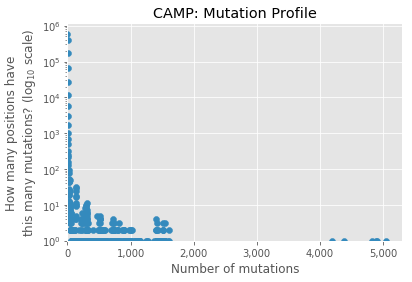

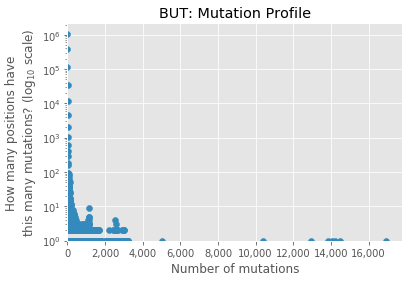

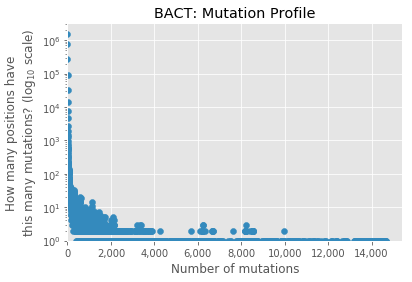

In [6]:
view_mutation_profiles(logscale=True)

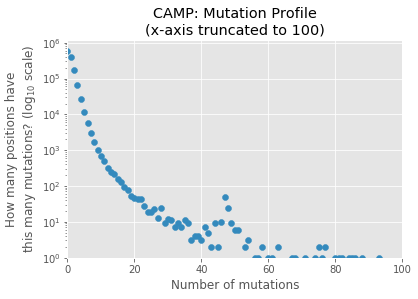

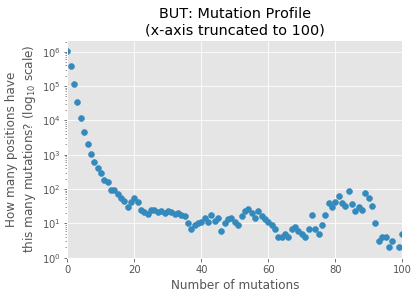

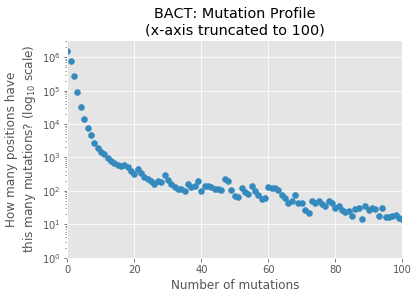

In [7]:
view_mutation_profiles(xlim_max=100, logscale=True)

## Compute uni-mutational fractions: $N_1$, $N_2$, $N_3$ for each position in the genome

NOTE: in the paper we use different numbers (N2 instead of N1, etc), but the idea is the same

(We make the simplifying assumption in the following text that all reads contain only nucleotides, and don't contain degenerate bases like $Y$ or $N$.)

For a genomic position $P$ with a reference nucleotide $R \in \{A, C, G, T\}$, we consider three values: $N_1$, $N_2$, and $N_3$. __Ignoring reads aligned to $P$ that match $R$__, a read aligned to $P$ can have one of three other nucleotides at this position (for example, if $R$ is $A$, then these "non-matching" reads should only describe $C$, $G$, or $T$).

$N_1$, $N_2$, and $N_3$ define the number of non-matching reads aligned to $P$ for each of these three remaining nucleoides, such that $N_1 \geq N_2 \geq N_3$:

- $N_1$ is the number of non-matching reads that contain the most common "alternate" nucleotide at $P$.
- $N_2$ is the number of non-matching reads for the second-most common "alternate" nucleotide at $P$.
- $N_3$ is the number of non-matching reads for the third-most (least) common "alternate" nucleotide at $P$.

For example, if a given position in a reference sequence is $G$ and the covering reads for this position are:

- 100 $G$
- 1 $T$
- 50 $C$
- 5 $A$

Then we would say that $N_1$ = 50 (for $C$), $N_2$ = 5 (for $A$), and $N_3$ = 1 (for $T$).

We note that, for low-coverage and/or stable genomic positions, some or all of $N_1$, $N_2$, and $N_3$ may be zero.

We are interested in computing $f = \dfrac{N_1}{N_1 + N_2 + N_3}$ (which is only defined when $N_1 > 0$).

For a position with reasonably high coverage, high values of this fraction (at most $f = 1$) indicate that the metagenome likely has one primary "alternate" nucleotide at this position, while lower values (at lowest $f = \dfrac{1}{3}$) indicate that there are likely multiple "common" alternate nucleotides.

In [8]:
seq2pos2f = {}
for seq in SEQS:
    seq2pos2f[seq] = {}
    for pos in seq2pos2matchct[seq]:
        non_matches = seq2pos2mismatches[seq][pos]
        if len(non_matches) > 0:
            non_match_cts = non_matches.values()
            f = max(non_match_cts) / sum(non_match_cts)
            seq2pos2f[seq][pos] = f
#             if max(non_match_cts) > seq2pos2matchct[seq][pos]:
#                 print("Seq {} at pos {} has reference that isn't consensus of aligned reads.".format(
#                     seq2name[seq], pos
#                 ))
#                 print("Num matches: {}, mismatches: {}".format(seq2pos2matchct[seq][pos], non_matches))
        else:
            # There are no non-matches, so N1, N2, and N3 are all 0. This means that f is undefined
            # (since it'd be 0 / 0).
            seq2pos2f[seq][pos] = None
            
# The following code computes "f" across the genomes.
# The plots are... not very informative.
#     pyplot.scatter([int(x) for x in seq2pos2f[seq].keys()], seq2pos2f[seq].values(), c=SCATTERPLOT_PT_COLOR)
#     pyplot.title("{}: f across genome, where defined and where coverage $\geq$ {}".format(
#         seq2name[seq], MIN_COV
#     ))
#     pyplot.xlabel("Sequence position")
#     pyplot.ylabel(r"$\dfrac{N_1}{N_1 + N_2 + N_3}$")
#     pyplot.locator_params(axis="x", nbins=5)
#     use_thousands_sep(pyplot.gca().xaxis)
#     pyplot.show()

## Save mutation profiles (and other associated data) to files

In [9]:
def get_all_mutation_profile_data(
    seq,
    geneloc="/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal"
):
    """Partially copied from get_mutation_profile(), but extended."""

    num_mutations_to_freq = defaultdict(int)
    num_mutations_to_fvals = defaultdict(list)
    num_mutations_to_avgf = defaultdict(int)
    num_mutations_to_unimutational_pos_ct = defaultdict(int)
    num_mutations_to_unimutational_pos_ct_frac = defaultdict(int)
    # Number of CP 1/2/3 and non-coding positions with N mutations
    # (You can think of these as sort of individual mutation profiles limited to specific "types" of
    # positions in a genome)
    num_mutations_to_cp1ct = defaultdict(int)
    num_mutations_to_cp2ct = defaultdict(int)
    num_mutations_to_cp3ct = defaultdict(int)
    num_mutations_to_ncpct = defaultdict(int)
    
    genes = parse_sco("{}/{}_genes.sco".format(geneloc, seq))
    # maps positions to a list of the CPs they are. (It's a list, and not just an integer, b/c of overlapping
    # genes -- a given position could be in CP 1 of one gene and CP 2 of an overlapping gene, for example...
    # we could also just filter positions shared in multiple genes, but the other analyses here don't do that
    # so for consistency's sake we continue to "double-count" positions sometimes)
    pos2cptypes = defaultdict(set)
    # TODO: abstract gene iteration to helper function; I've reused this code a lot in this notebook
    for gene in genes.itertuples():
        i = 1
        # (note that positions returned by get_pos_interval_from_gene() are ints, while seq2pos2...
        # stuff use string positions. This is wack and ideally should be made easier to work with)
        for pos in get_pos_interval_from_gene(gene):
            pos2cptypes[str(pos)].add(i)
            if i == 1: i = 2
            elif i == 2: i = 3
            elif i == 3: i = 1
            else: raise ValueError("Codon position modulo calculation is broken :|")
        if i != 1: raise ValueError("Gene length not divisible by 3")
    
    for pos in seq2pos2matchct[seq]:
        # ignore uncovered places. Could also ignore places with less than some threshold coverage
        # (e.g. 5) if desired
        if seq2pos2matchct[seq][pos] + seq2pos2mismatchct[seq][pos] == 0:
            continue
        
        # Most important part - figure out how many mutations this position has
        mutct = seq2pos2mismatchct[seq][pos]
        
        # Update frequency (main point of the mutation profile)
        num_mutations_to_freq[mutct] += 1
        # Update CP / non-coding pos cts
        cptypes = pos2cptypes[pos]
        if len(cptypes) == 0:
            num_mutations_to_ncpct[mutct] += 1
        else:
            # NOTE: This is an inelegant way of writing this - ideally these would all be one structure
            for cp in cptypes:
                if cp == 1: num_mutations_to_cp1ct[mutct] += 1
                elif cp == 2: num_mutations_to_cp2ct[mutct] += 1
                elif cp == 3: num_mutations_to_cp3ct[mutct] += 1
                else: raise ValueError("Unrecognized CP type")
                    
        if seq2pos2f[seq][pos] is None:
            # This means f is undefined because there are no alternate bases at this position.
            if mutct == 0:
                if len(seq2pos2mismatches[seq][pos]) > 0:
                    raise ValueError("uh oh")
                num_mutations_to_fvals[mutct].append(seq2pos2f[seq][pos])
            else:
                # Previously, this case could happen accidentally due to deletions messing with things. Now it
                # shouldn't ever happen.
                raise ValueError("Found undefined f at position {} in {} with alternate bases".format(pos, seq))
        else:
            num_mutations_to_fvals[mutct].append(seq2pos2f[seq][pos])
            if len(seq2pos2mismatches[seq][pos]) == 1:
                num_mutations_to_unimutational_pos_ct[mutct] += 1

    # Now that we've gone through all positions in this sequence, update some aggregate stats (avg.
    # uni-mutational fraction [aka average f-value]; fraction of uni-mutational positions).
    # Note that we iterate through this range - not just the keys of num_mutations_to_freq - because
    # we want to look over the places where there are 0 mutations, which are implicitly not included in
    # num_mutations_to_freq since it's a defaultdict
    for i in range(0, max(num_mutations_to_freq.keys()) + 1):
        if num_mutations_to_freq[i] > 0:
            if None in num_mutations_to_fvals[i]:
                if i == 0:
                    avg_f = "N/A"
                else:
                    raise ValueError("Something is bad")
            else:
                if len(num_mutations_to_fvals[i]) == 0:
                    raise ValueError("Something went horribly wrong... deletion error again?")
                else:
                    avg_f = sum(num_mutations_to_fvals[i]) / len(num_mutations_to_fvals[i])
        else:
            avg_f = "N/A"
        # I'm aware that the use of an underscore in "avg_f" should be more consistent; sorry ._.
        num_mutations_to_avgf[i] = avg_f

        # This is the fraction of positions with this many mutations which are uni-mutational.
        # So, 100% of positions with exactly one mutation are uni-mutational (so this is 1),
        # and so on. Of course, if there are 0 positions with a given number of mutations,
        # then we'd have to divide by 0 to compute this -- so we just call it "N/A" for these rows.
        if num_mutations_to_freq[i] > 0:
            num_mutations_to_unimutational_pos_ct_frac[i] = num_mutations_to_unimutational_pos_ct[i] / num_mutations_to_freq[i]
        else:
            num_mutations_to_unimutational_pos_ct_frac[i] = "N/A"
            
    data = {
        "num_mutations_to_freq": num_mutations_to_freq,
        "num_mutations_to_cp1ct": num_mutations_to_cp1ct,
        "num_mutations_to_cp2ct": num_mutations_to_cp2ct,
        "num_mutations_to_cp3ct": num_mutations_to_cp3ct,
        "num_mutations_to_ncpct": num_mutations_to_ncpct,
        "num_mutations_to_unimutational_pos_ct": num_mutations_to_unimutational_pos_ct,
        "num_mutations_to_unimutational_pos_ct_frac": num_mutations_to_unimutational_pos_ct_frac,
        "num_mutations_to_avg_unimutational_fraction": num_mutations_to_avgf,
    }
    return data

In [ ]:
def save_mutation_profile(seq, output_dir="/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph"):
    data = get_all_mutation_profile_data(seq)

    out_fn = os.path.join(output_dir, "{}_mutation_profile.tsv".format(seq2name[seq]))
    with open(out_fn, "w") as tsvf:
        headerline = "\t".join((
            "Number of mutations",
            "Number of positions with this many mutations",
            "Number of CP 1 positions with this many mutations",
            "Number of CP 2 positions with this many mutations",
            "Number of CP 3 positions with this many mutations",
            "Number of non-coding positions with this many mutations",
            "Number of uni-mutational positions with this many mutations",
            "Fraction of positions which are uni-mutational",
            "Average uni-mutational fraction of positions with this many mutations"
        )) + "\n"
        tsvf.write(headerline)
        for i in range(0, max(data["num_mutations_to_freq"].keys()) + 1):
            tsvf.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
                i,
                data["num_mutations_to_freq"][i],
                data["num_mutations_to_cp1ct"][i],
                data["num_mutations_to_cp2ct"][i],
                data["num_mutations_to_cp3ct"][i],
                data["num_mutations_to_ncpct"][i],
                data["num_mutations_to_unimutational_pos_ct"][i],
                data["num_mutations_to_unimutational_pos_ct_frac"][i],
                data["num_mutations_to_avg_unimutational_fraction"][i],
            ))
for seq in SEQS:
    save_mutation_profile(seq)

In [ ]:
# plot # of mutations against average unimutational fraction
xlim_max = 100
for seq in SEQS:
    n2a = get_all_mutation_profile_data(seq)["num_mutations_to_avg_unimutational_fraction"]
    
    for i in range(0, xlim_max + 1):
        if type(n2a[i]) != str:
            pyplot.scatter(i, n2a[i], c=SCATTERPLOT_PT_COLOR)

    pyplot.xlabel("Number of mutations")
    pyplot.ylabel("Average uni-mutational fraction")

    title = "{}: Average uni-mutational fraction\nfor all positions with $n$ mutations".format(seq2name[seq])
    title += "\n(x-axis truncated to {})".format(xlim_max)
    pyplot.xlim(0)
    pyplot.ylim(0.3, 1.05)
    pyplot.title(title)
#     use_thousands_sep(pyplot.gca().xaxis)
    pyplot.show()

In [ ]:
# plot mutation profiles: # of mutations against # of (uni-mutational) positions
# two variants of these, one with an x-max of 100 (to focus on "low" numbers of mutations)
# and another with no x-max
for xmax in [100, None]:
    for seq in SEQS:
        data = get_all_mutation_profile_data(seq)

        largest_mutct = max(data["num_mutations_to_freq"].keys()) if xmax is None else xmax
        for i in range(0, largest_mutct + 1):
            # Only plot #s of mutations with at least one occurrence
            if data["num_mutations_to_freq"][i] > 0:
                pyplot.scatter(i, data["num_mutations_to_freq"][i], c=SCATTERPLOT_PT_COLOR,
                               label="" if i > 0 else "Total Number of Positions")
                pyplot.scatter(i, data["num_mutations_to_unimutational_pos_ct"][i], c="#e24a33",
                               label="" if i > 0 else "Number of Uni-Mutational Positions")

        # Need to use symlog in order to 
        pyplot.yscale("symlog")
        pyplot.ylim(0)

        pyplot.xlabel("Number of mutations")        
        ylabel = "How many (uni-mutational) positions have\nthis many mutations?"
        ylabel += " (log$_{10}$ scale)"
        pyplot.ylabel(ylabel)

        title = "{}: Mutation profile".format(seq2name[seq])
        if xmax is not None: title += "\n(x-axis truncated to {})".format(xmax)
        pyplot.title(title)
        pyplot.legend()
        pyplot.show()

## Plot histograms of $\frac{N_1}{N_1 + N_2 + N_3}$ over all third-CP positions in each sequence

In [ ]:
from parse_sco import parse_sco

for seq in SEQS:
    df = parse_sco(
        "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq)
    )
    # Go through each gene in this sequence. Find the (third) CPs. Record their "f" value, if present. Plot
    # a histogram of these f-values.
    num2fvals = {1: [], 2: [], 3: []}
    for gene in df.itertuples():
        i = 1
        for pos in get_pos_interval_from_gene(gene):
            f = seq2pos2f[seq][str(pos)]            
            if f is not None and f < 1:
                num2fvals[i].append(f)
            if i == 1:
                i = 2
            elif i == 2:
                i = 3
            elif i == 3:
                i = 1
            else:
                raise ValueError("Codon position modulo calculation is broken :|")

        if i != 1:
            raise ValueError("Gene length not divisible by 3.")
    
    for cp in [1, 2, 3]:
        print("{}, CP {}: mean (valid, non-1) f-value = {}, num valid non-1 f-values = {:,}".format(
            seq2name[seq], cp, mean(num2fvals[cp]), len(num2fvals[cp])
        ))
        pyplot.hist(num2fvals[cp], bins=20)
        pyplot.title("{}: CP {}".format(seq2name[seq], cp) + " non-1 uni-mutational fractions")
        pyplot.xlabel(r"$\dfrac{N_2}{N_2 + N_3 + N_4}$")
        pyplot.ylabel("Frequency")
        use_thousands_sep(pyplot.gca().yaxis)
        # This is a hack to make all CP plots in a row have the same y-axis. Ideally this'd be automatic
        # but uhhhh elbow grease is easier lol
        if seq2name[seq] == "CAMP":
            pyplot.ylim(0, 28000)
        elif seq2name[seq] == "BUT":
            pyplot.ylim(0, 18000)
        else:
            pyplot.ylim(0, 35000)
        pyplot.show()